In [11]:
import pandas as pd
import numpy as np
import requests
import spacy
import logging
import os 
import re
import ast
import json
import datetime
import gzip
from datetime import datetime, timedelta
from dateutil import parser, relativedelta
from localutils import cveutils

# set up the current date and time as one string
current_date = datetime.now().strftime('%Y-%m-%d')
current_time = datetime.now().strftime('%H:%M:%S')


#Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"logs/app-{current_date+current_time}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ExploitDB
from pyExploitDb import PyExploitDb
pEdb = PyExploitDb()
pEdb.debug = False
pEdb.openFile()


In [ ]:
cveutils.download_nvd_cve_data(2005, 2025, "data/download")
cveutils.unzip_files("data/download")

cves = cveutils.load_nvd_cve_data("data/download")
# Sort by CVE ID
cves = cves.sort_values(by="cve_id")

cves.to_csv("output/cves_2004-2025.csv", index=False)
today_date = datetime.now().strftime("%Y-%m-%d")
epss_file = cveutils.download_epss_scores(today_date, "data/download")
epss_scores = pd.read_csv(epss_file, skiprows=1)
cves_with_epss = pd.merge(cves,epss_scores, left_on="cve_id", right_on="cve", how="left")
cves_with_epss.drop(columns=["cve"], inplace=True)
cves_with_epss.to_csv("output/cves_with_epss_2004-2025.csv", index=False)


In [21]:
# Convert numeric columns to appropriate types
numeric_columns = ['base_score', 'exploitability_score', 'impact_score']

# Convert numeric columns for cves DataFrame
for col in numeric_columns:
	cves[col] = pd.to_numeric(cves[col], errors='coerce')

# Convert numeric columns for cves_with_epss DataFrame
for col in numeric_columns:
	cves_with_epss[col] = pd.to_numeric(cves_with_epss[col], errors='coerce')

# dump to .parquet
cves.to_parquet("output/cves_2005-2025.parquet", index=False)
cves_with_epss.to_parquet("output/cves_with_epss_2005-2025.parquet", index=False)

In [ ]:
kevs = cveutils.download_known_exploited_vulnerabilities()

# simulate identified vulns outcome
outcome_cves = cves_with_epss.sample(1000)
outcome_cves.drop(columns=["scope", "confidentiality_impact", "integrity_impact", "availability_impact"], inplace=True)
outcome_cves = outcome_cves.apply(cveutils.update_row_with_details, axis=1)
outcome_cves.to_csv("output/sample1000_cves_epss_enriched-20250215.csv", index=False)

Analyse cve descriptions to find relevant Categories and re-assess original CVSS impact
(use spacy.io)

In [ ]:
outcome_cves.columns

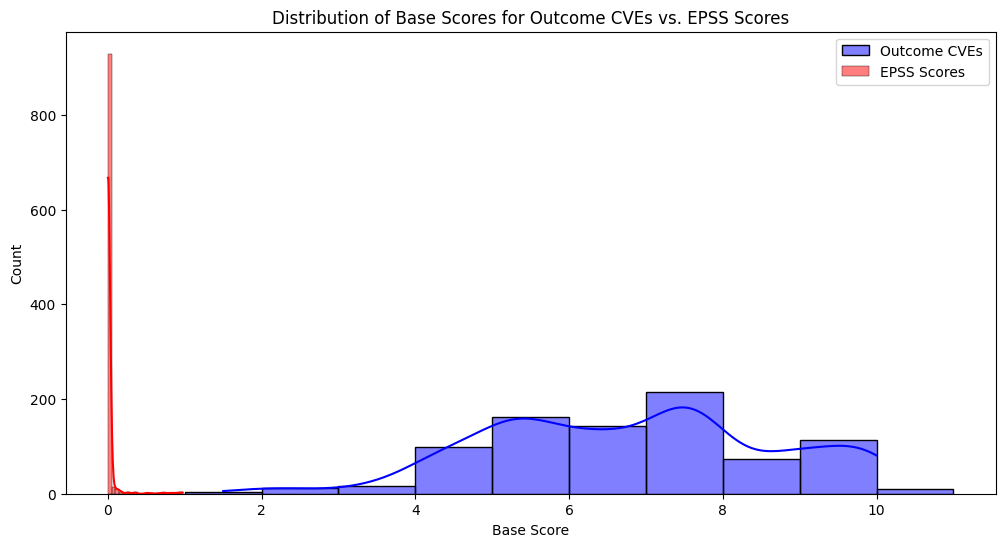

In [22]:
# plot the distribution of the base scores for the outcome cves versus EPSS scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(outcome_cves["base_score"], bins=20, kde=True, color="blue", label="Outcome CVEs")
sns.histplot(outcome_cves["epss"], bins=20, kde=True, color="red", label="EPSS Scores")
plt.title("Distribution of Base Scores for Outcome CVEs vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("Count")
plt.legend()
plt.savefig("output/base_scores_distribution.png")
plt.show()


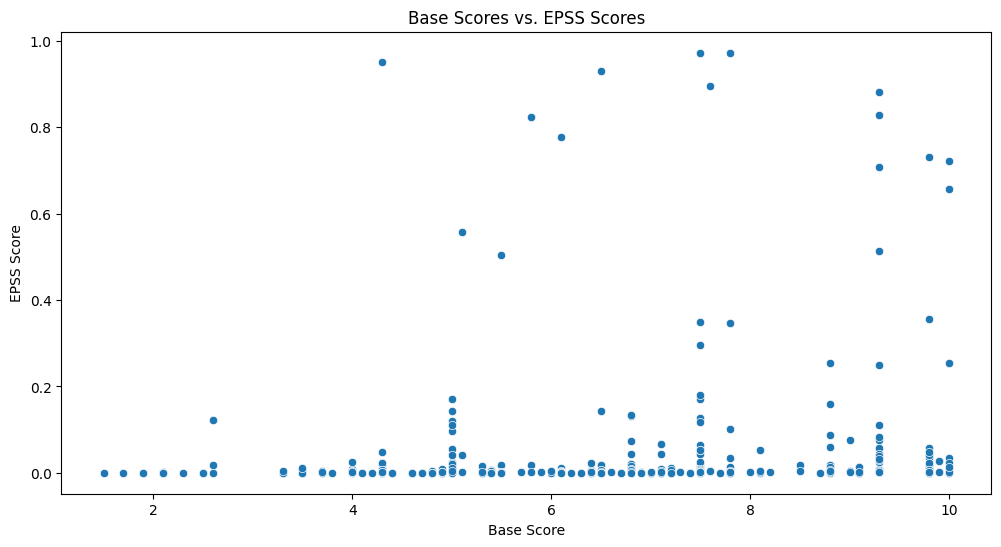

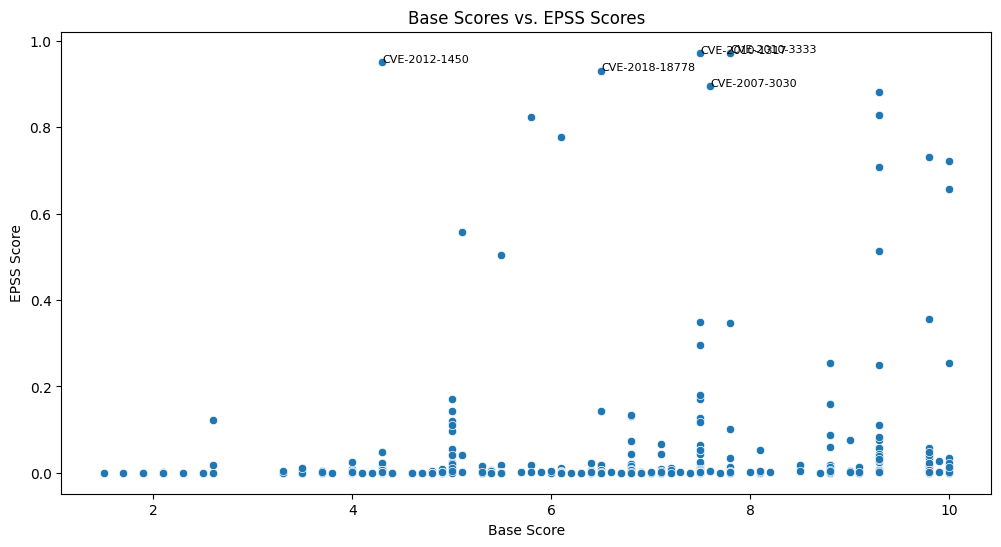

In [23]:
# generate plot with CVE scores in X and EPSS scores in Y
plt.figure(figsize=(12, 6))
sns.scatterplot(x="base_score", y="epss", data=outcome_cves)
plt.title("Base Scores vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("EPSS Score")
plt.savefig("output/base_vs_epss_scores.png")
plt.show()

# add labels of the CVEs with the highest EPSS scores
highest_epss = outcome_cves.nlargest(5, "epss")
plt.figure(figsize=(12, 6))
sns.scatterplot(x="base_score", y="epss", data=outcome_cves)
for i, row in highest_epss.iterrows():
    plt.text(row["base_score"], row["epss"], row["cve_id"], fontsize=8)
plt.title("Base Scores vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("EPSS Score")
plt.savefig("output/base_vs_epss_scores_with_labels.png")
plt.show()

In [24]:
# show Bayes' theorem  for the outcome cves with EPSS scores and the known exploited vulnerabilities data 
# calculate the probabilities
total_cves = len(cves_with_epss)
total_kevs = len(kevs)
total_epss = len(cves_with_epss[cves_with_epss["epss"].notnull()])
total_epss_kevs = len(kevs[kevs["cveID"].isin(cves_with_epss["cve_id"])])
total_epss_not_kevs = total_epss - total_epss_kevs
total_kevs_not_epss = total_kevs - total_epss_kevs
total_not_epss = total_cves - total_epss
# calculate the probabilities
# Calculate proper probabilities using only the total_cves as the base
p_kevs = total_kevs / total_cves  # P(KEV)
p_epss = total_epss / total_cves  # P(EPSS)
p_kevs_and_epss = total_epss_kevs / total_cves  # P(KEV ∩ EPSS)
p_kevs_given_epss = p_kevs_and_epss / p_epss if p_epss > 0 else 0  # P(KEV|EPSS)
p_epss_given_kevs = p_kevs_and_epss / p_kevs if p_kevs > 0 else 0  # P(EPSS|KEV)
p_kevs_and_not_epss = total_kevs_not_epss / total_cves  # P(KEV ∩ ¬EPSS)
# print the probabilities
print(f"Total CVEs: {total_cves}")
print(f"Total KEVs: {total_kevs}")
print(f"Total EPSS: {total_epss}")
print(f"Total EPSS KEVs: {total_epss_kevs}")
print(f"Total EPSS not KEVs: {total_epss_not_kevs}")
print(f"Total KEVs not EPSS: {total_kevs_not_epss}")
print(f"Total not EPSS: {total_not_epss}")
print(f"Probability of KEVs: {p_kevs}")
print(f"Probability of EPSS: {p_epss}")
print(f"Probability of KEVs and EPSS: {p_kevs_and_epss}")
print(f"Probability of KEVs given EPSS: {p_kevs_given_epss}")
print(f"Probability of EPSS given KEVs: {p_epss_given_kevs}")
print(f"Probability of KEVs and not EPSS: {p_kevs_and_not_epss}")



Total CVEs: 273133
Total KEVs: 1271
Total EPSS: 269760
Total EPSS KEVs: 1270
Total EPSS not KEVs: 268490
Total KEVs not EPSS: 1
Total not EPSS: 3373
Probability of KEVs: 0.004653410609483292
Probability of EPSS: 0.9876507049679094
Probability of KEVs and EPSS: 0.0046497493894915665
Probability of KEVs given EPSS: 0.0047078884934756825
Probability of EPSS given KEVs: 0.999213217938631
Probability of KEVs and not EPSS: 3.661219991725643e-06


In [26]:
# probability of KEVs given EPSS score > 0.1
epss_threshold = 0.1

# Merge KEVs with EPSS scores
kevs_with_epss = pd.merge(kevs, epss_scores, left_on='cveID', right_on='cve', how='left')

# Filter KEVs with EPSS score above threshold
epss_kevs = kevs_with_epss[kevs_with_epss["epss"] > epss_threshold]
epss_kevs_count = len(epss_kevs)
epss_kevs_prob = epss_kevs_count / total_cves

print(f"Total KEVs with EPSS > {epss_threshold}: {epss_kevs_count}")
print(f"Probability of KEVs with EPSS > {epss_threshold}: {epss_kevs_prob:.4f}")

Total KEVs with EPSS > 0.1: 734
Probability of KEVs with EPSS > 0.1: 0.0027


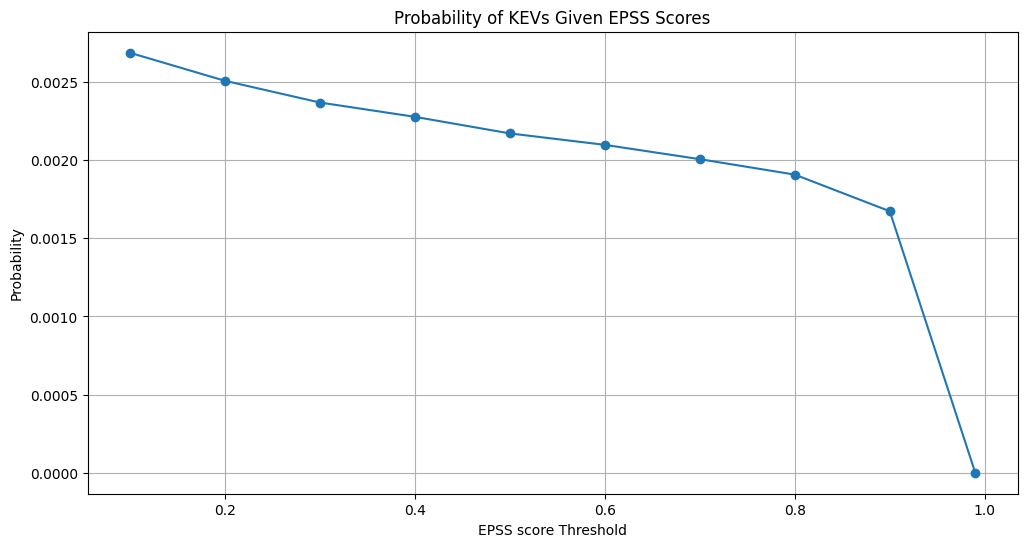

In [28]:
# distribution of probabilities of KEVs given EPSS scores 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
epss_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
kevs_probabilities = []
for threshold in epss_thresholds:
    epss_kevs = kevs_with_epss[kevs_with_epss["epss"] > threshold]
    epss_kevs_count = len(epss_kevs)
    epss_kevs_prob = epss_kevs_count / total_cves
    kevs_probabilities.append(epss_kevs_prob)

# plot the distribution of probabilities of KEVs given EPSS scores
plt.figure(figsize=(12, 6))
plt.plot(epss_thresholds, kevs_probabilities, marker='o')
plt.title("Probability of KEVs Given EPSS Scores")
plt.xlabel("EPSS score Threshold")
plt.ylabel("Probability")
plt.grid()
plt.savefig("output/kevs_probability_vs_epss_threshold.png")
plt.show()

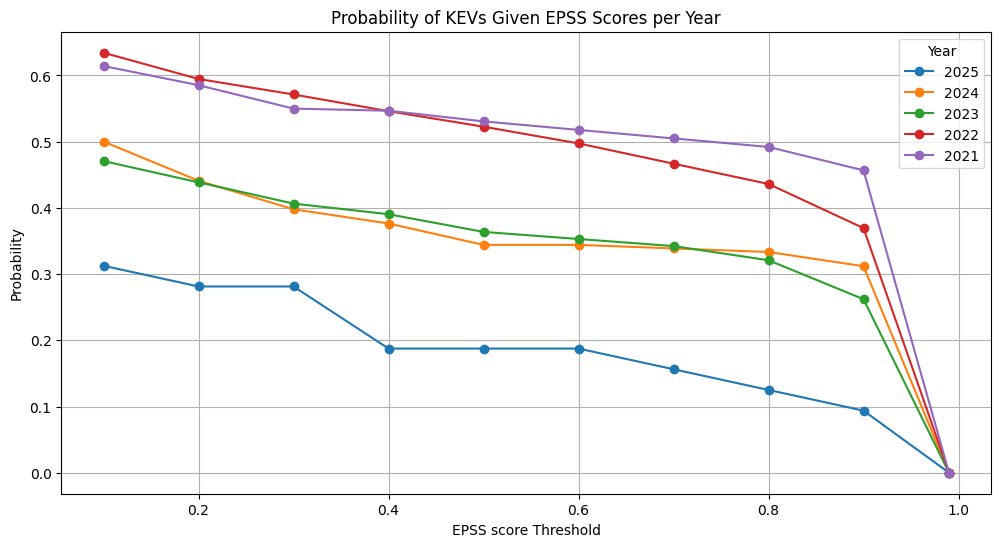

In [34]:
# calculate the probabilities of KEVs given EPSS scores per year in last 5 years
kevs_with_epss["year"] = pd.to_datetime(kevs_with_epss["dateAdded"]).dt.year
years = kevs_with_epss["year"].unique()
kevs_probabilities_per_year = []
for year in years:
    kevs_per_year = kevs_with_epss[kevs_with_epss["year"] == year]
    total_cves_per_year = len(kevs_per_year)
    kevs_probabilities_year = []
    for threshold in epss_thresholds:
        epss_kevs = kevs_per_year[kevs_per_year["epss"] > threshold]
        epss_kevs_count = len(epss_kevs)
        epss_kevs_prob = epss_kevs_count / total_cves_per_year
        kevs_probabilities_year.append(epss_kevs_prob)
    kevs_probabilities_per_year.append(kevs_probabilities_year)

# plot the distribution of probabilities of KEVs given EPSS scores per year
plt.figure(figsize=(12, 6))
for i, year in enumerate(years):
    plt.plot(epss_thresholds, kevs_probabilities_per_year[i], marker='o', label=year)
plt.title("Probability of KEVs Given EPSS Scores per Year")
plt.xlabel("EPSS score Threshold")
plt.ylabel("Probability")
plt.legend(title="Year")
plt.grid()
plt.savefig("output/kevs_probability_vs_epss_threshold_per_year.png")
plt.show()

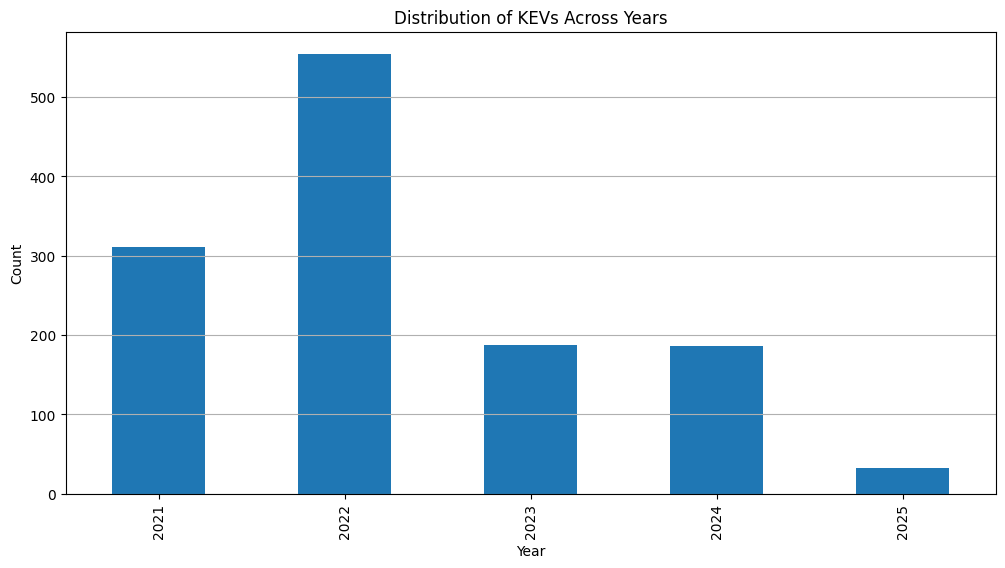

In [30]:
# KEVs distribution across years
kevs["year"] = pd.to_datetime(kevs["dateAdded"]).dt.year
kevs_yearly = kevs.groupby("year").size()
kevs_yearly.plot(kind="bar", figsize=(12, 6))
plt.title("Distribution of KEVs Across Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(axis="y")
plt.savefig("output/kevs_distribution_years.png")
plt.show()


In [ ]:
files_to_process = cveutils.epss_time_machine(24, "data/download/EPSS", unit='months')

In [7]:
epss_dfs = []
for i, file in enumerate(files_to_process):
    with open(file, "r") as f:
        first_line = f.readline().strip()
        score_date = first_line.split(",")[1].split(":")[1].strip().split("T")[0]
        score_date = datetime.strptime(score_date, "%Y-%m-%d").strftime("%Y-%m-%d")
    epss_df = pd.read_csv(file, skiprows=1)
    epss_df["epss_tuple"] = list(zip(epss_df["epss"], epss_df["percentile"]))
    epss_df = epss_df.drop(columns=["epss", "percentile"])
    epss_df = epss_df.rename(columns={"epss_tuple": score_date})
    if i == 0:
        epss_scores = epss_df
    else:
        epss_scores = epss_df.drop(columns="cve")
    epss_dfs.append(epss_scores)
    logger.info(f"Processed EPSS scores for date {score_date}")

epss_scores = pd.concat(epss_dfs, axis=1)

2025-02-15 21:25:10,733 - INFO - Processed EPSS scores for date 2025-01-31
2025-02-15 21:25:11,149 - INFO - Processed EPSS scores for date 2024-12-31
2025-02-15 21:25:11,578 - INFO - Processed EPSS scores for date 2024-11-30
2025-02-15 21:25:12,019 - INFO - Processed EPSS scores for date 2024-10-31
2025-02-15 21:25:12,437 - INFO - Processed EPSS scores for date 2024-09-30
2025-02-15 21:25:12,850 - INFO - Processed EPSS scores for date 2024-08-31
2025-02-15 21:25:13,268 - INFO - Processed EPSS scores for date 2024-07-31
2025-02-15 21:25:13,679 - INFO - Processed EPSS scores for date 2024-06-30
2025-02-15 21:25:14,077 - INFO - Processed EPSS scores for date 2024-05-31
2025-02-15 21:25:14,444 - INFO - Processed EPSS scores for date 2024-04-30
2025-02-15 21:25:14,871 - INFO - Processed EPSS scores for date 2024-03-31
2025-02-15 21:25:15,327 - INFO - Processed EPSS scores for date 2024-02-29
2025-02-15 21:25:15,734 - INFO - Processed EPSS scores for date 2024-01-31
2025-02-15 21:25:16,079 -

In [9]:
epss_scores.columns

Index(['cve', '2025-01-31', '2024-12-31', '2024-11-30', '2024-10-31',
       '2024-09-30', '2024-08-31', '2024-07-31', '2024-06-30', '2024-05-31',
       '2024-04-30', '2024-03-31', '2024-02-29', '2024-01-31', '2023-12-31',
       '2023-11-30', '2023-10-31', '2023-09-30', '2023-08-31', '2023-07-31',
       '2023-06-30', '2023-05-31', '2023-04-30', '2023-03-31', '2023-02-28'],
      dtype='object')

In [ ]:
# clean and normalize before dump
# drop all rows for CVES older than 2020 and drop all rows with missing values
epss_scores = epss_scores[epss_scores["cve"].str.contains("CVE-2020|CVE-2021|CVE-2022|CVE-2023|CVE-2024|CVE-2025")]
epss_scores = epss_scores.dropna()
# make all scores type: float
for col in epss_scores.columns[1:]:
    epss_scores[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)
epss_scores = epss_scores.reset_index(drop=True)

epss_scores.to_parquet("output/epss_scores_monthly_2020-2025.parquet", index=False)

In [14]:
epss_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53331 entries, 0 to 53330
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cve                53331 non-null  object 
 1   2025-01-31         53331 non-null  object 
 2   2024-12-31         53331 non-null  object 
 3   2024-11-30         53331 non-null  object 
 4   2024-10-31         53331 non-null  object 
 5   2024-09-30         53331 non-null  object 
 6   2024-08-31         53331 non-null  object 
 7   2024-07-31         53331 non-null  object 
 8   2024-06-30         53331 non-null  object 
 9   2024-05-31         53331 non-null  object 
 10  2024-04-30         53331 non-null  object 
 11  2024-03-31         53331 non-null  object 
 12  2024-02-29         53331 non-null  object 
 13  2024-01-31         53331 non-null  object 
 14  2023-12-31         53331 non-null  object 
 15  2023-11-30         53331 non-null  object 
 16  2023-10-31         533

In [13]:
epss_scores.to_parquet("output/epss_scores_monthly_2020-2025.parquet", index=False)

In [132]:
epss_scores_sc = epss_scores[["cve"]]
for col in epss_scores.columns[1:]:
    epss_scores_sc[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)

/tmp/ipykernel_8684/3637404753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epss_scores_sc[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)
/tmp/ipykernel_8684/3637404753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epss_scores_sc[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)
/tmp/ipykernel_8684/3637404753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [107]:
epss_scores_sc

,cve,scores_2025-01-31,scores_2024-12-31,scores_2024-11-30,scores_2024-10-31,scores_2024-09-30,scores_2024-08-31,scores_2024-07-31,scores_2024-06-30,scores_2024-05-31,scores_2024-04-30,scores_2024-03-31,scores_2024-02-29
0,CVE-2020-0001,0.00042,0.00044,0.00043,0.00105,0.00042,0.00093,0.02857,0.00112,0.01393,0.00042,0.00144,0.02876
1,CVE-2020-0002,0.00123,0.00044,0.00145,0.00109,0.00042,0.00042,0.00241,0.02160,0.01393,0.00168,0.95706,0.00131
2,CVE-2020-0003,0.00042,0.00932,0.00102,0.00109,0.00042,0.00093,0.93145,0.00478,0.00422,0.00378,0.95884,0.00212
3,CVE-2020-0004,0.00085,0.00042,0.00102,0.00109,0.00109,0.00042,0.00755,0.00042,0.00090,0.01294,0.00093,0.00063
4,CVE-2020-0005,0.00044,0.00044,0.00102,0.00109,0.00147,0.00042,0.10246,0.00862,0.00090,0.00089,0.00097,0.00063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94141,CVE-2023-52712,0.00043,0.00125,0.00063,0.00049,0.00106,0.00075,0.00043,0.00045,0.00124,0.00043,0.00068,0.00058
94142,CVE-2023-52713,0.00043,0.00061,0.00067,0.00045,0.00087,0.00066,0.00046,0.00043,0.00050,0.00043,0.00047,0.00058
94143,CVE-2023-52714,0.00043,0.00071,0.00108,0.00080,0.00386,0.00090,0.00087,0.00053,0.00043,0.00052,0.00050,0.00045
94144,CVE-2023-52715,0.00046,0.00133,0.00406,0.00076,0.00053,0.00089,0.00043,0.00051,0.00063,0.00049,0.00155,0.00045


ModuleNotFoundError: No module named 'plotly'

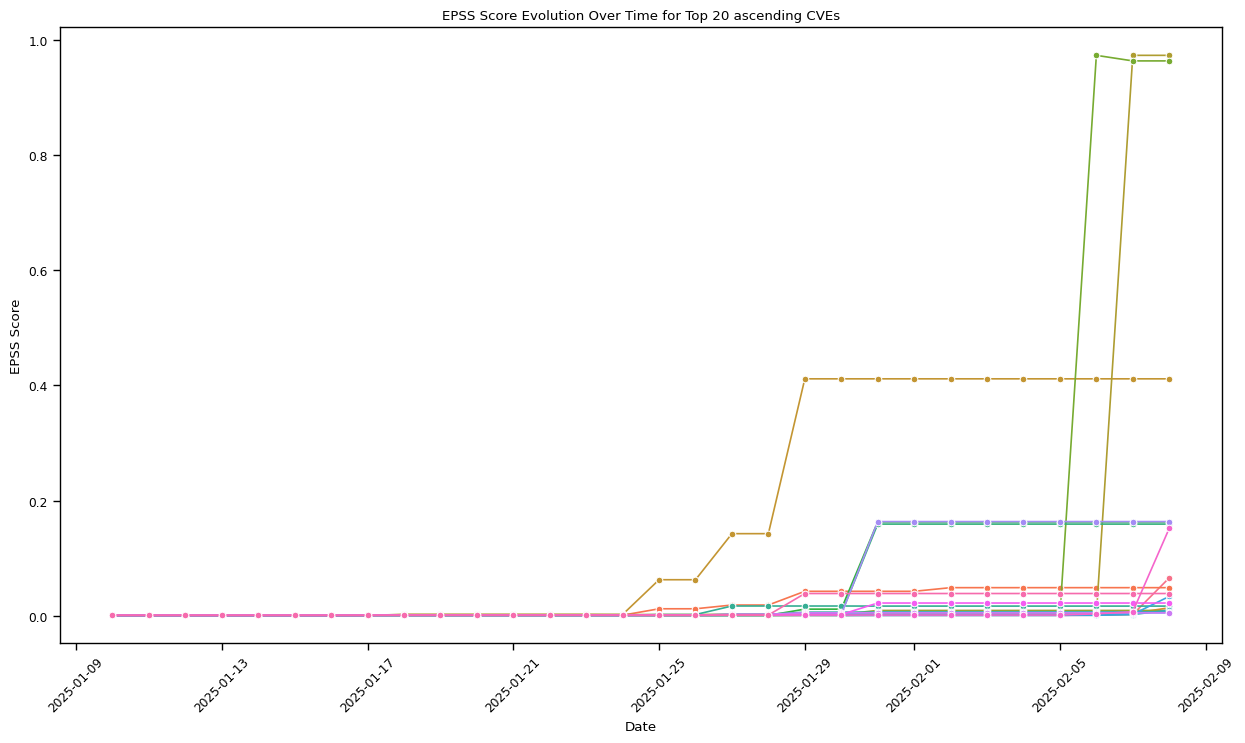

In [150]:
import seaborn as sns

# find all CVE with the highest ascending rate across the months starting from the oldest month to the latest month
epss_scores_sc["rate"] = epss_scores_sc.iloc[:, 1:].pct_change(axis=1).mean(axis=1)
epss_scores_sc = epss_scores_sc.sort_values(by="rate", ascending=True)
top_cves = epss_scores_sc.head(20)
top_cves = top_cves.drop(columns="rate")
top_cves = top_cves.set_index("cve").T

# Create a DataFrame with dates and scores, excluding non-date rows
date_rows = [idx for idx in top_cves.index if idx.startswith('scores_')]
top_cves_filtered = top_cves.loc[date_rows]
top_cves_filtered["date"] = [d.replace("scores_", "") for d in top_cves_filtered.index]

# Melt and process the data
melted_df = top_cves_filtered.melt(id_vars="date", var_name="cve", value_name="score")
melted_df["date"] = pd.to_datetime(melted_df["date"])
melted_df = melted_df.sort_values("date")

# Plot the results
plt.figure(figsize=(15, 8))
sns.set_context("paper", font_scale=1)
lines = sns.lineplot(data=melted_df, x="date", y="score", hue="cve", marker="o", legend=False)
plt.title("EPSS Score Evolution Over Time for Top 20 ascending CVEs")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("EPSS Score")
# Add CVE labels at the end points, slightly offset for better visibility
import plotly.express as px
import plotly.graph_objects as go

# Melt the data for plotly
melted_data = melted_df.copy()

# Create figure
fig = go.Figure()

# Add traces for each CVE
for cve in melted_data['cve'].unique():
    cve_data = melted_data[melted_data['cve'] == cve]
    fig.add_trace(go.Scatter(
        x=cve_data['date'],
        y=cve_data['score'],
        name=f"{cve} ({cve_data['score'].iloc[-1]:.5f})",
        mode='lines+markers'
    ))

# Update layout
fig.update_layout(
    title='EPSS Score Evolution Over Time for Top 20 ascending CVEs',
    xaxis_title='Date',
    yaxis_title='EPSS Score',
    hovermode='x unified',
    width=1200,
    height=800,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05
    )
)

fig.show()





In [138]:
# show what is the fraction of the top ascending scores CVES within the number of CVEs
top_cves_count = len(top_cves)
total_cves_count = len(epss_scores_sc)
top_cves_fraction = top_cves_count / total_cves_count
print(f"Top ascending scores CVEs: {top_cves_count}")
print(f"Total CVEs: {total_cves_count}")
print(f"Fraction of Top ascending scores CVEs: {top_cves_fraction:.2f}")


Top ascending scores CVEs: 30
Total CVEs: 129860
Fraction of Top ascending scores CVEs: 0.00
